# Fuel efficiency prediction

### Data Exploration and Preprocessing

In [220]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, sep=' ', skipinitialspace=True, comment='\t', names=columns, na_values='?')

df.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
53,31.0,4,71.0,65.0,1773.0,19.0,71,3
258,20.6,6,231.0,105.0,3380.0,15.8,78,1
151,31.0,4,79.0,67.0,2000.0,16.0,74,2
24,21.0,6,199.0,90.0,2648.0,15.0,70,1
288,18.2,8,318.0,135.0,3830.0,15.2,79,1


In [221]:
# Check datatypes and nan-values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


There are some NaN values in `Horsepower` so we get rid of them from the dataframe:

In [222]:
df.dropna(inplace=True)

Now split the dataframe into training and testing subsets:

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train and test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=13)

print(df_train.shape, df_test.shape)
df_train.sample(5, random_state=13)

(313, 8) (79, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
103,11.0,8,400.0,150.0,4997.0,14.0,73,1
209,19.0,4,120.0,88.0,3270.0,21.9,76,2
41,14.0,8,318.0,150.0,4096.0,13.0,71,1
21,24.0,4,107.0,90.0,2430.0,14.5,70,2
25,10.0,8,360.0,215.0,4615.0,14.0,70,1


Normalize numerical features:

In [224]:
numeric_cols = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

scaler = StandardScaler()

df_train_norm = df_train.copy()
df_test_norm = df_test.copy()
df_train_norm[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test_norm[numeric_cols] = scaler.transform(df_test[numeric_cols])

df_train_norm.sample(5, random_state=13)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
103,11.0,1.510167,2.004739,1.231129,2.404023,-0.591780,73,1
209,19.0,-0.832744,-0.696375,-0.403246,0.360361,2.264544,76,2
41,14.0,1.510167,1.213698,1.231129,1.337816,-0.953340,71,1
21,24.0,-0.832744,-0.821784,-0.350524,-0.633661,-0.411000,70,2
25,10.0,1.510167,1.618865,2.944585,1.951980,-0.591780,70,1


Bucketize numerical feature `Model Year`

In [225]:
import torch

boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)
v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_cols.append('Model Year Bucketed')

Encode categorical feature `Origin`

In [226]:
uniques_origin = len(df_train_norm['Origin'].unique())

from torch.nn.functional import one_hot

# map 1,2,3 Origin values to 0,1,2, for correct onehot encoding
origin_onehot = one_hot(torch.tensor(df_train_norm['Origin'].values)-1, num_classes=uniques_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_cols].values)
x_train = torch.cat([x_train_numeric, origin_onehot], dim=1).float() # concat encoded to normalized features along columns

origin_onehot = one_hot(torch.tensor(df_test_norm['Origin'].values)-1, num_classes=uniques_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_cols].values)
x_test = torch.cat([x_test_numeric, origin_onehot], dim=1).float()

Define targets:

In [227]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

### Training Deep Neural Network

Create dataloader with a batch size of 8 for the later Mini-batch GD:

In [228]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(13)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Now we build the model with 2 fully connected layers with 8 and 4 hidden units respectively:

In [229]:
hidden_units = [8, 4]
layers = []

import torch.nn as nn

input_size = x_train.shape[1] # number of features

for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    layers.append(layer)
    layers.append(nn.ReLU())
    input_size = hidden_unit # update input for next layer
    
# Output layer
layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

Now we define the loss function and create the SGD for the mini-batch GD:

In [230]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00075)

Now we train the model with 200 epochs:

In [231]:
torch.manual_seed(1310)
n_epochs = 200

loss_hist = []

for epoch in range(n_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:,0] # [8,1] -> [8]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
        
    avg_loss = loss_hist_train / len(train_dl)
    loss_hist.append(avg_loss)

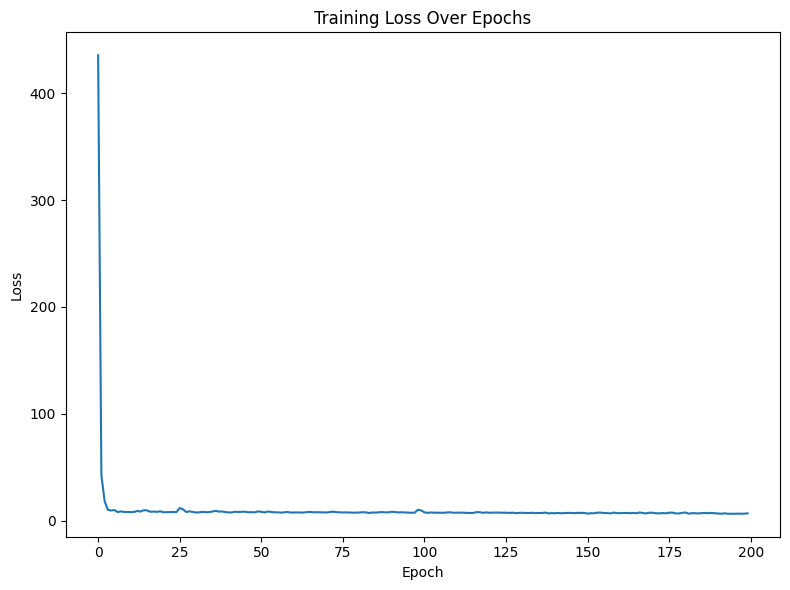

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

df_loss = pd.DataFrame({
    'Epoch': range(n_epochs),
    'Loss': loss_hist
})

plt.figure(figsize=(8, 6))
sns.lineplot(x='Epoch', y='Loss', data=df_loss,)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.tight_layout()

The learning curve shows a rapid decrease in training loss during the initial epochs, followed by a stabilization period where the loss remains consistently low. This indicates that the model quickly learns the underlying patterns early in the training process and then fine-tunes its performance.  

Now let's see the performance on the test set:

In [233]:
with torch.no_grad():
    pred = model(x_test.float())[:,0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}\n'
          f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 9.6232
Test MAE: 2.3450
